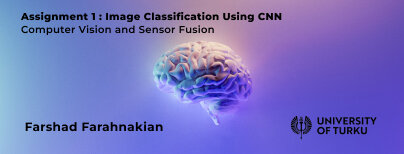

The Goal of assignment is to understand the effect of image agumentation on the model performance in the classification task.

Dataset: The image data that was used for this problem is the brain tumor dataset MRI Images for Brain Tumor Detection. It consists of MRI scans of two classes:
1. NO tumor, labelled as 0 >>> 98 images 
2. YES - tumor, labelled as 1 >>> 155 images

# Import Packages
Import all the packages needed for this notebook in one cell

In [405]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.layers import Dropout
from PIL import Image

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import shutil, random, os
import glob
import matplotlib.pyplot as plt
import random
import cv2
import skimage as ski
import imutils

# Pre-processing dataset (cleaning and resizing)

In [218]:
destination_path = [
    'C:/Users/farfar/Downloads/brain_tumor_dataset/brain_tumor_dataset/no',
    'C:/Users/farfar/Downloads/brain_tumor_dataset/brain_tumor_dataset/yes',
]

In [219]:
save_path = [
    'C:/Users/farfar/Downloads/brain_tumor_dataset/brain_tumor_dataset/no/no_new',
    'C:/Users/farfar/Downloads/brain_tumor_dataset/brain_tumor_dataset/yes/yes_new/',
]

The below function is able to get a folder including images in different format (in this case .png, .bmp, .tiff, and JPEG) and convert them into the same format (jpg) as some of the images in the orginal format were in different format.

In [220]:
def convert_image_to_same_type(folder_path, save_path):
    for filename in os.listdir(folder_path):
        if filename.endswith((".png",".bmp",".tiff",".jpg",".jpeg", "JPG")):
            # Open the image file
            with Image.open(os.path.join(folder_path, filename)) as im:
                # Convert the image to RGB
                im = im.convert("RGB")
                # Save the image as a JPEG into a folder in the same directory named "new" 
                im.save(os.path.join(save_path, filename.split('.')[0]+'.jpg'))
        else:
            continue

In [221]:
# let's converting the image to the same type (.jpg)
convert_image_to_same_type(destination_path[0], save_path[0])
convert_image_to_same_type(destination_path[1], save_path[1])

In [222]:
def crop_brain_contour(image, plot=False):

    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    return new_image

In [225]:
# path to the folder containing the images
img_folder_path = ['C:/Users/farfar/Downloads/brain_tumor_dataset/brain_tumor_dataset/no/no_new/',
                   'C:/Users/farfar/Downloads/brain_tumor_dataset/brain_tumor_dataset/yes/yes_new/']
# path to save the output images
save_path = ['C:/Users/farfar/Downloads/brain_tumor_dataset/brain_tumor_dataset/no/no_new/no_croped/',
             'C:/Users/farfar/Downloads/brain_tumor_dataset/brain_tumor_dataset/yes/yes_new/yes_croped/']

def applied_croped_function(img_folder_path, save_path):
             for filename in os.listdir(img_folder_path):
                 if filename.endswith(".jpg"):
                     # read the image
                     image = cv2.imread(os.path.join(img_folder_path, filename))
                     # apply the crop_brain_contour function
                     new_image = crop_brain_contour(image)
                     # save the output image
                     cv2.imwrite(os.path.join(save_path, filename), new_image)

In [226]:
# let's applied croped function and save into two seperate folders
applied_croped_function(img_folder_path[0], save_path[0]) # for no class
applied_croped_function(img_folder_path[1], save_path[1]) # for yes class

Now, it is time to resize all images into the same size (128.128)

In [227]:
def resize_image(folder_path, resize_path):
    for filename in os.listdir(folder_path):
        if filename.endswith((".jpg")):
            # Open the image file
            with Image.open(os.path.join(folder_path, filename)) as im:
                # Resize the image
                im_resized = im.resize((128, 128))
                # Save the resized image
                im_resized.save(os.path.join(resize_path, 'resized_'+filename))
        else:
            continue

In [228]:
resize_path = ['C:/Users/farfar/Downloads/brain_tumor_dataset/brain_tumor_dataset/no/no_new/no_croped/no_resize',
               'C:/Users/farfar/Downloads/brain_tumor_dataset/brain_tumor_dataset/yes/yes_new/yes_croped/yes_resize']

In [229]:
# let's resizing 
resize_image(save_path[0], resize_path[0])
resize_image(save_path[1], resize_path[1])

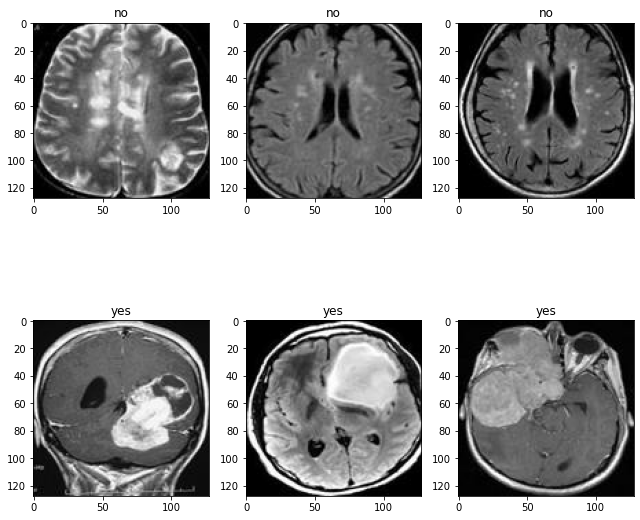

In [230]:
# Checking samples by visualizing some of images randomly
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(9, 9))
for h, folder in enumerate(resize_path):
    for k, filename in enumerate(glob.glob(folder + "/*.jpg")[6:9]):
        img = ski.io.imread(filename)
        axs[h,k].imshow(img)
        axs[h,k].set_title(filename.split("/")[6].split("_")[0])
plt.tight_layout();

# Splitting Data (Train and Test)

In the following code, the glob library is used to find all the images in the "no_class" and "yes_class" folders and load them into separate arrays. Then, the images and labels are combined and passed to the train_test_split function along with the test size of 0.2 and a random state of 42. This will split the data into training and testing sets, where 80% of the data is used for training, and 20% is used for testing.

In [425]:
# Load the images from the 'no class' folder
no_class = []
for filename in os.listdir(resize_path[0]):
        if filename.endswith(".jpg"):
            image = Image.open(os.path.join(resize_path[0], filename))
            no_class.append(np.array(image))
    
# Load the images from the 'yes class' folder
yes_class = []
for filename in os.listdir(resize_path[1]):
        if filename.endswith(".jpg"):
            image = Image.open(os.path.join(resize_path[1], filename))
            yes_class.append(np.array(image))
    
# Combine the images from the two folders
images = no_class + yes_class
images = shuffle(images)

In [426]:
no_class_count = len(no_class)
yes_class_count = len(yes_class)

# Count the number of images in each class
print("Number of images in no class:", no_class_count)
print("Number of images in yes class:", yes_class_count)

# Count the total number of images
total_count = no_class_count + yes_class_count
print("Total number of images:", total_count)

Number of images in no class: 98
Number of images in yes class: 155
Total number of images: 253


In [427]:
# Create labels for the images (0 for no_class, 1 for yes_class)
labels = [0] * len(no_class) + [1] * len(yes_class)
len(labels)

253

In [428]:
# Iterate over the combined images and labels
for i in range(len(images)):
    # Create an Image object from the image data
    img = Image.fromarray(images[i])
    # Determine the label of the image
    label = labels[i]
    # Define the filename based on the label
    filename = "image_{}_{}.jpg".format(label, i)
    # Save the image to a file
    img.save(os.path.join("C:/Users/farfar/Downloads/brain_tumor_dataset/brain_tumor_dataset/Mix", filename))

In [429]:
# Split the data into 80% training and 20% testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

In [430]:
import pandas as pd

# Create a dataframe from X_train and y_train
df = pd.DataFrame({'X_train':X_train,'y_train': y_train})

# Check the distribution of classes
print(df['y_train'].value_counts())


1    124
0     78
Name: y_train, dtype: int64


In [294]:
df

,X_train,y_train
0,"[[[12, 12, 12], [12, 12, 12], [12, 12, 12], [1...",0
1,"[[[29, 29, 29], [29, 29, 29], [29, 29, 29], [2...",0
2,"[[[4, 4, 4], [4, 4, 4], [4, 4, 4], [4, 4, 4], ...",0
3,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",1
4,"[[[32, 32, 30], [32, 32, 30], [32, 32, 30], [3...",0
...,...,...
197,"[[[6, 6, 6], [6, 6, 6], [6, 6, 6], [6, 6, 6], ...",1
198,"[[[9, 9, 9], [9, 9, 9], [9, 9, 9], [9, 9, 9], ...",0
199,"[[[23, 23, 23], [25, 25, 25], [26, 26, 26], [2...",1
200,"[[[1, 1, 1], [0, 0, 0], [0, 0, 0], [1, 1, 1], ...",1


In [431]:
# Convert the data to numpy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [432]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(202, 128, 128, 3)
(51, 128, 128, 3)
(202,)
(51,)


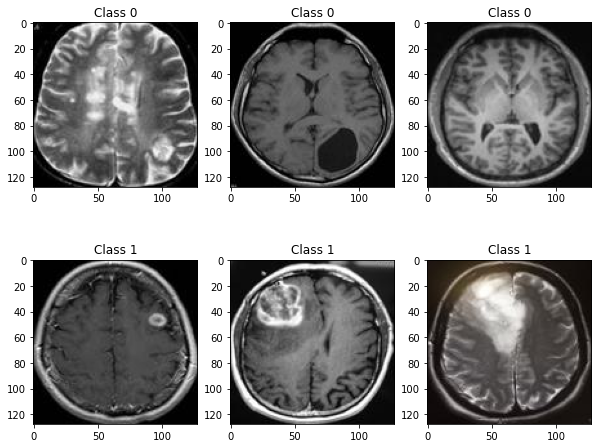

In [238]:
import matplotlib.pyplot as plt

# Get the first three images of class 0 (no)
no_class_images = X_train[y_train == 0][:3]

# Get the first three images of class 1 (yes)
yes_class_images = X_train[y_train == 1][:3]

# Create a figure with 6 subplots (3 for each class)
fig, axes = plt.subplots(2,3, figsize=(10,8))

# Display the first three images of class 0 in the first three subplots
for i, ax in enumerate(axes[0]):
    ax.imshow(no_class_images[i])
    #ax.axis('off')
    ax.set_title('Class 0')

# Display the first three images of class 1 in the last three subplots
for i, ax in enumerate(axes[1]):
    ax.imshow(yes_class_images[i])
    #ax.axis('off')
    ax.set_title('Class 1')

# Show the figure
plt.show()

In [433]:
# Normalize data is by using the mean and standard deviation of the data
X_train = (X_train - X_train.mean()) / X_train.std()
X_test = (X_test - X_test.mean()) / X_test.std()

In [434]:
print(X_train.dtype)
print(y_train.dtype)

float64
int32


In [435]:
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')

In [436]:
X_train.shape

(202, 128, 128, 3)

# Building CNN Model 

In [391]:
# Create a sequential model
model = Sequential()

# Add the first convolutional layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
# Add the first max pooling layer
model.add(MaxPooling2D((2, 2)))

# Add the second convolutional layer
model.add(Conv2D(32, (3, 3), activation='relu'))
# Add the second max pooling layer
model.add(MaxPooling2D((2, 2)))

# Add the third convolutional layer
model.add(Conv2D(64, (3, 3), activation='relu'))
# Add the third max pooling layer
model.add(MaxPooling2D((2, 2)))

# Add the forth convolutional layer
model.add(Conv2D(128, (3, 3), activation='relu'))
# Add the fourth max pooling layer
model.add(MaxPooling2D((2, 2)))

# Flatten the output from the convolutional layers
model.add(Flatten())
# Add a fully connected layer with a ReLU activation function
model.add(Dense(512, activation='relu'))

# Add the final output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss=binary_crossentropy, metrics=['accuracy'])

In [392]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_56 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_61 (Conv2D)          (None, 61, 61, 32)        9248      
                                                                 
 max_pooling2d_57 (MaxPoolin  (None, 30, 30, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_62 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_58 (MaxPoolin  (None, 14, 14, 64)     

# Training Model

Epoch 1/10
7/7 [==============================] - 2s 189ms/step - loss: 0.8954 - accuracy: 0.5149 - val_loss: 0.6926 - val_accuracy: 0.5294
Epoch 2/10
7/7 [==============================] - 1s 169ms/step - loss: 0.6834 - accuracy: 0.5792 - val_loss: 0.6658 - val_accuracy: 0.6078
Epoch 3/10
7/7 [==============================] - 1s 169ms/step - loss: 0.6683 - accuracy: 0.6139 - val_loss: 0.6709 - val_accuracy: 0.6078
Epoch 4/10
7/7 [==============================] - 1s 167ms/step - loss: 0.6626 - accuracy: 0.6139 - val_loss: 0.6704 - val_accuracy: 0.6078
Epoch 5/10
7/7 [==============================] - 1s 172ms/step - loss: 0.6568 - accuracy: 0.6139 - val_loss: 0.6703 - val_accuracy: 0.6078
Epoch 6/10
7/7 [==============================] - 1s 170ms/step - loss: 0.6524 - accuracy: 0.6337 - val_loss: 0.6668 - val_accuracy: 0.6078
Epoch 7/10
7/7 [==============================] - 1s 168ms/step - loss: 0.6362 - accuracy: 0.6386 - val_loss: 0.6793 - val_accuracy: 0.5882
Epoch 8/10
7/7 [====

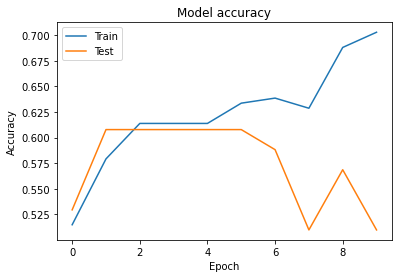

In [393]:
# Define callbacks for early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True, save_weights_only=True)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

# Plot the model accuracy for the training and validation phases
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Prediction

In [394]:

# Make predictions on the test dataset
test_predictions = model.predict(X_test)

# Convert predictions to class labels
test_predictions = np.argmax(test_predictions, axis=1)

# Select 5 random examples from the test dataset
random_indices = random.sample(range(len(X_test)), 5)

# Show the predicted results for the 5 random examples
for i in random_indices:
    print("Example {}: True label = {}, Predicted label = {}".format(i, y_test[i], test_predictions[i]))

2/2 [==============================] - 0s 22ms/step
Example 44: True label = 1, Predicted label = 0
Example 2: True label = 0, Predicted label = 0
Example 7: True label = 0, Predicted label = 0
Example 25: True label = 1, Predicted label = 0
Example 12: True label = 0, Predicted label = 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


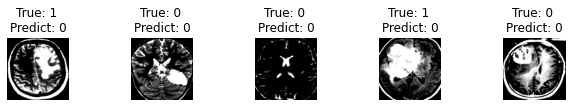

In [395]:
# Plot the random examples
fig, axes = plt.subplots(1, 5, figsize=(10,10))
axes = axes.ravel()

for i, ax in enumerate(axes):
    image = cv2.resize(X_test[random_indices[i]], (150, 150))
    ax.imshow(image, cmap='gray')
    ax.set_title("True: %s \nPredict: %s" % (y_test[random_indices[i]], test_predictions[random_indices[i]]))
    ax.axis('off')

plt.subplots_adjust(wspace=1)
plt.show()


##### Discussion (1/3):

The loss and accuracy values optained indicate that the model is performing well overall, but there may be some overfitting. The training accuracy (0.7030) is higher than the validation accuracy (0.5098), which suggests that the model is performing better on the training data than on new, unseen data. 

# Applying Agumentation Technique

In [437]:
from keras.preprocessing.image import ImageDataGenerator

# Create a data generator
datagen = ImageDataGenerator(
        rotation_range=40, # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2, # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2, # randomly shift images vertically (fraction of total height)
        shear_range=0.15, # set range for random shear
        zoom_range=0.15, # set range for random zoom
        horizontal_flip=True, # randomly flip images
        fill_mode='nearest')

# Fit the ImageDataGenerator to the training data
datagen.fit(X_train)

In [438]:
X_train.shape

(202, 128, 128, 3)

In [439]:
# Use the generator to generate augmented versions of the training data
X_train_augmented = X_train.copy()
y_train_augmented = y_train.copy()
for x_batch, y_batch in datagen.flow(X_train, y_train, batch_size=32):
    x_batch = x_batch.astype(X_train.dtype)
    y_batch = y_batch.astype(y_train.dtype)
    X_train_augmented = np.concatenate((X_train_augmented, x_batch))
    y_train_augmented = np.concatenate((y_train_augmented, y_batch))
    if X_train_augmented.shape[0] >= 5 * X_train.shape[0]:
        break

In [440]:
X_train_augmented.shape

(1010, 128, 128, 3)

In [400]:
# Save the agumantion images to check them 
for i in range(len(X_train_augmented)):
    # Create an Image object from the image data
    img = Image.fromarray(np.uint8(X_train_augmented[i]))
    # Determine the label of the image
    label = y_train_augmented[i]
    # Define the filename based on the label
    filename = "image_{}_{}.jpg".format(label, i)
    # Save the image to a file
    img.save(os.path.join("C:/Users/farfar/Downloads/brain_tumor_dataset/brain_tumor_dataset/Agumantion", filename))

In [401]:
# Fit the model on the augmented data
history = model.fit(X_train_augmented, y_train_augmented, validation_data=(X_test, y_test), batch_size=32, epochs=20)

Epoch 1/20
7/7 [==============================] - 1s 170ms/step - loss: 0.5378 - accuracy: 0.7178 - val_loss: 0.7533 - val_accuracy: 0.5490
Epoch 2/20
7/7 [==============================] - 1s 166ms/step - loss: 0.4472 - accuracy: 0.7871 - val_loss: 0.8682 - val_accuracy: 0.5294
Epoch 3/20
7/7 [==============================] - 1s 165ms/step - loss: 0.4394 - accuracy: 0.8119 - val_loss: 0.8898 - val_accuracy: 0.5686
Epoch 4/20
7/7 [==============================] - 1s 165ms/step - loss: 0.3854 - accuracy: 0.8218 - val_loss: 1.0687 - val_accuracy: 0.4510
Epoch 5/20
7/7 [==============================] - 1s 170ms/step - loss: 0.3696 - accuracy: 0.8515 - val_loss: 1.1312 - val_accuracy: 0.5098
Epoch 6/20
7/7 [==============================] - 1s 174ms/step - loss: 0.3112 - accuracy: 0.8713 - val_loss: 1.0810 - val_accuracy: 0.4314
Epoch 7/20
7/7 [==============================] - 1s 170ms/step - loss: 0.3127 - accuracy: 0.8911 - val_loss: 1.1963 - val_accuracy: 0.4706
Epoch 8/20
7/7 [====

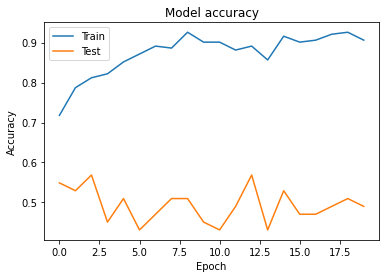

In [402]:
# Plot the model accuracy for the training and validation phases
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


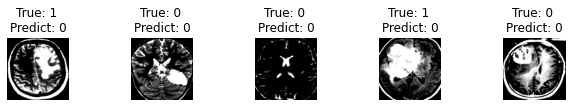

In [403]:
# Plot the random examples
fig, axes = plt.subplots(1, 5, figsize=(10,10))
axes = axes.ravel()

for i, ax in enumerate(axes):
    image = cv2.resize(X_test[random_indices[i]], (150, 150))
    ax.imshow(image, cmap='gray')
    ax.set_title("True: %s \nPredict: %s" % (y_test[random_indices[i]], test_predictions[random_indices[i]]))
    ax.axis('off')

plt.subplots_adjust(wspace=1)
plt.show()


##### Discussion (2/3):

According to the loss, accuracy, val_loss, and val_accuracy values, the model is overfitting to the training data.The training loss (0.2013) and accuracy (0.9059) are quite low and high respectively, which indicates that the model is performing well on the training data. However, the validation loss (1.3637) and accuracy (0.4902) are much higher and lower respectively, which suggests that the model is not performing well on new, unseen data.

To address the overfitting issue, I used regularization methods (dropout). The rate of dropout is set to 0.25 in this case, which means that 25% of the neurons in the layer will be randomly dropped out during training.

# Applying Regularization Method (dropout)

In [441]:
# Create a sequential model
model = Sequential()

# Add the first convolutional layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
# Add the first max pooling layer
model.add(MaxPooling2D((2, 2)))
# Add dropout layer with rate of 0.25
model.add(Dropout(0.25))

# Add the second convolutional layer
model.add(Conv2D(32, (3, 3), activation='relu'))
# Add the second max pooling layer
model.add(MaxPooling2D((2, 2)))
# Add dropout layer with rate of 0.25
model.add(Dropout(0.25))

# Add the third convolutional layer
model.add(Conv2D(64, (3, 3), activation='relu'))
# Add the third max pooling layer
model.add(MaxPooling2D((2, 2)))
# Add dropout layer with rate of 0.25
model.add(Dropout(0.25))

# Add the forth convolutional layer
model.add(Conv2D(128, (3, 3), activation='relu'))
# Add the fourth max pooling layer
model.add(MaxPooling2D((2, 2)))
# Add dropout layer with rate of 0.25
model.add(Dropout(0.25))

# Flatten the output from the convolutional layers
model.add(Flatten())
# Add a fully connected layer with a ReLU activation function
model.add(Dense(512, activation='relu'))

# Add the final output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss=binary_crossentropy, metrics=['accuracy'])

In [442]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_69 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_65 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 63, 63, 32)        0         
                                                                 
 conv2d_70 (Conv2D)          (None, 61, 61, 32)        9248      
                                                                 
 max_pooling2d_66 (MaxPoolin  (None, 30, 30, 32)       0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 30, 30, 32)      

In [443]:
# Fit the model on the augmented data
history = model.fit(X_train_augmented, y_train_augmented, validation_data=(X_test, y_test), batch_size=32, epochs=40)

Epoch 1/40
32/32 [==============================] - 10s 296ms/step - loss: 0.7357 - accuracy: 0.5950 - val_loss: 0.6753 - val_accuracy: 0.6078
Epoch 2/40
32/32 [==============================] - 9s 283ms/step - loss: 0.6731 - accuracy: 0.6139 - val_loss: 0.6791 - val_accuracy: 0.6078
Epoch 3/40
32/32 [==============================] - 9s 283ms/step - loss: 0.6674 - accuracy: 0.6139 - val_loss: 0.6760 - val_accuracy: 0.6078
Epoch 4/40
32/32 [==============================] - 9s 282ms/step - loss: 0.6664 - accuracy: 0.6139 - val_loss: 0.6745 - val_accuracy: 0.6078
Epoch 5/40
32/32 [==============================] - 9s 282ms/step - loss: 0.6667 - accuracy: 0.6168 - val_loss: 0.6783 - val_accuracy: 0.6078
Epoch 6/40
32/32 [==============================] - 9s 283ms/step - loss: 0.6662 - accuracy: 0.6178 - val_loss: 0.6679 - val_accuracy: 0.6078
Epoch 7/40
32/32 [==============================] - 9s 286ms/step - loss: 0.6581 - accuracy: 0.6188 - val_loss: 0.6725 - val_accuracy: 0.5882
Epoch

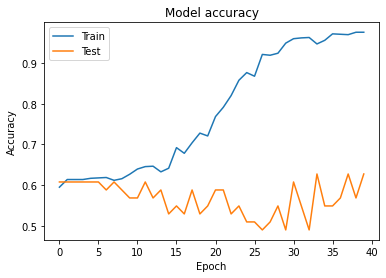

In [444]:
# Plot the model accuracy for the training and validation phases
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


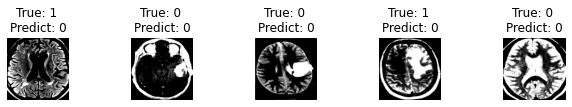

In [445]:
# Plot the random examples
fig, axes = plt.subplots(1, 5, figsize=(10,10))
axes = axes.ravel()

for i, ax in enumerate(axes):
    image = cv2.resize(X_test[random_indices[i]], (150, 150))
    ax.imshow(image, cmap='gray')
    ax.set_title("True: %s \nPredict: %s" % (y_test[random_indices[i]], test_predictions[random_indices[i]]))
    ax.axis('off')

plt.subplots_adjust(wspace=1)
plt.show()


##### Discussion (3/3):

It looks like the model is performing well on the training set (low training loss and high training accuracy), but is not performing as well on the validation set (high validation loss and lower validation accuracy). This can be an indication of overfitting, which means that the model is doing well on the training data but not as well on unseen data.

I have added dropout in the model but the regularization rate is not specified. In the future, I will try specifying the rate of dropout I want to add after each pooling layer, for example rate = 0.3. I can also try adding more data to my training set or use data augmentation techniques.

# End of Assignment-1 (Author: Farshad Farahnakian, Email: farfar@utu.fi)